## DOCUMENT SCANNER

In [101]:
# Importing necessary libraries for the Document Scanner project

# For image processing and computer vision
import cv2
import numpy as np
import imutils  # Utility functions for image resizing, rotation, etc.

# For adaptive thresholding
from skimage.filters import threshold_local

# For visualizing results
import matplotlib.pyplot as plt

## IMAGE PREPROCESSING and EDGE DETECTION


In [102]:
def image_preprocess(img):
    """
    Preprocesses the input image for document scanning.

    Args:
        img (numpy.ndarray): The input image in BGR format.

    Returns:
        tuple: A tuple containing:
            - image (numpy.ndarray): Resized version of the original image.
            - edged (numpy.ndarray): Edge-detected image.
            - ratio (float): Scale ratio between the original and resized image.
    """

    # Make a copy of the input image to preserve the original
    image = img.copy()

    # Calculate the scaling ratio and resize the image to a fixed height of 500 pixels
    ratio = image.shape[0] / 500.0
    image = imutils.resize(image, height=500)

    # Convert the image to RGB format for consistency
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    gray = cv2.GaussianBlur(gray, (7, 7), 0)

    # Perform edge detection
    edged = cv2.Canny(gray, 50, 200)

    # Visualize the original image and the edge-detected result side by side
    fig = plt.figure(figsize=(10, 10))

    # Display the original image
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title("Original Image")
    ax1.axis("off")  # Hide axes
    ax1.imshow(image)

    # Display the edge-detected image
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_title("Edged Image")
    ax2.axis("off")  # Hide axes
    ax2.imshow(edged, cmap="gray")

    plt.show()

    # Return the resized image, edge-detected image, and scaling ratio
    return image, edged, ratio


## CONTOURS DETECTION on CANNY IMAGE

In [103]:
def contours(image, edged):
    """
    Identifies the contour of the document in the image using edge detection.

    Args:
        image (numpy.ndarray): The original resized image.
        edged (numpy.ndarray): Edge-detected image.

    Returns:
        numpy.ndarray: The contour of the document (approximated as a quadrilateral).
    """
    
    # Find all contours in the edge-detected image
    cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours by area in descending order and keep the largest 5
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

    # Loop over the sorted contours to find a quadrilateral
    screenCnt = None
    for c in cnts:
        # Calculate the perimeter of the contour
        peri = cv2.arcLength(c, True)
        
        # Approximate the contour with a polygon
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        
        # Check if the approximated contour has exactly 4 points
        if len(approx) == 4:
            screenCnt = approx
            break

    # Draw the detected contour (quadrilateral) on the original image
    if screenCnt is not None:
        cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
    else:
        raise ValueError("No document contour found!")

    # Visualize the image with the detected contour
    plt.figure(figsize=(7, 7))
    plt.title("Contour Image")
    plt.axis("off")  # Hide axes for better visualization
    plt.imshow(image)

    # Return the detected document contour
    return screenCnt


## APPLY a PERSPECTIVE TANSFORM and THRESHOLD

In [104]:
def order_points(pts):
    """
    Orders the points of a quadrilateral in a consistent order:
    top-left, top-right, bottom-right, and bottom-left.

    Args:
        pts (numpy.ndarray): Array of shape (4, 2) containing four points 
                             representing the corners of a quadrilateral.

    Returns:
        numpy.ndarray: Array of shape (4, 2) containing the ordered points.
                       The order is [top-left, top-right, bottom-right, bottom-left].
    """
    
    # Initialize an array to hold the ordered coordinates
    rect = np.zeros((4, 2), dtype="float32")
    
    # Calculate the sum of each point's coordinates
    # Top-left point will have the smallest sum, bottom-right the largest
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # Top-left
    rect[2] = pts[np.argmax(s)]  # Bottom-right
    
    # Calculate the difference between the x and y coordinates for each point
    # Top-right point will have the smallest difference, bottom-left the largest
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # Top-right
    rect[3] = pts[np.argmax(diff)]  # Bottom-left
    
    # Return the ordered coordinates
    return rect


In [105]:
def four_point_transform(image, pts):
    """
    Applies a perspective transform to obtain a top-down view of the document.

    Args:
        image (numpy.ndarray): The input image.
        pts (numpy.ndarray): Array of shape (4, 2) representing the four corners 
                             of the document in the image.

    Returns:
        numpy.ndarray: The warped image (top-down view of the document).
    """
    
    # Step 1: Order the points in a consistent manner
    rect = order_points(pts)  # Ensure points are in [top-left, top-right, bottom-right, bottom-left] order
    (tl, tr, br, bl) = rect  # Unpack the ordered points

    # Step 2: Compute the width of the new image
    # The width is the maximum distance between the bottom-right and bottom-left x-coordinates,
    # or between the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # Step 3: Compute the height of the new image
    # The height is the maximum distance between the top-right and bottom-right y-coordinates,
    # or between the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # Step 4: Define the destination points for the "birds-eye view" (top-down view)
    # The points are ordered as [top-left, top-right, bottom-right, bottom-left]
    dst = np.array([
        [0, 0],
        [maxWidth, 0],
        [maxWidth, maxHeight],
        [0, maxHeight]
    ], dtype="float32")

    # Step 5: Compute the perspective transform matrix and apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # Step 6: Return the warped (transformed) image
    return warped


In [106]:
def final_scanned(screenCnt, image, ratio):
    """
    Produces the final scanned (warped) image from the detected document contour.

    Args:
        screenCnt (numpy.ndarray): Contour points of the document (as a quadrilateral).
        image (numpy.ndarray): The original image.
        ratio (float): Scaling ratio between the original and resized image.

    Returns:
        None: Displays the original and scanned images side-by-side for comparison.
    """
    
    # Step 1: Create a copy of the original image
    orig = image.copy()

    # Step 2: Apply perspective transformation using the detected contour
    # Multiply the contour points by the scaling ratio to map them back to the original image size
    warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

    # Step 3: Optionally, convert the warped image to grayscale and apply thresholding
    # Uncomment the following lines if you want to give the scanned image a 'black-and-white paper' effect
    # warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    # T = threshold_local(warped, 11, offset=10, method="gaussian")
    # warped = (warped > T).astype("uint8") * 255

    # Step 4: Convert images to RGB format for consistent display in Matplotlib
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)

    # Step 5: Visualize the original and scanned images side-by-side
    fig = plt.figure(figsize=(15, 15))
    
    # Original image
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title("Original Image")
    ax1.axis("off")  # Hide axes for cleaner visualization
    ax1.imshow(orig)

    # Scanned (warped) image
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_title("Scanned Image")
    ax2.axis("off")  # Hide axes for cleaner visualization
    ax2.imshow(warped)

    # Display the figure
    plt.show()


## DOCUMENT SCANNER TESTING

# Example 1

In [107]:
img1 = cv2.imread('/home/user/Data Science Portfolio - Likitha/Projects/Document_Scanner/Document-Scanner/Images/image1.jpeg')

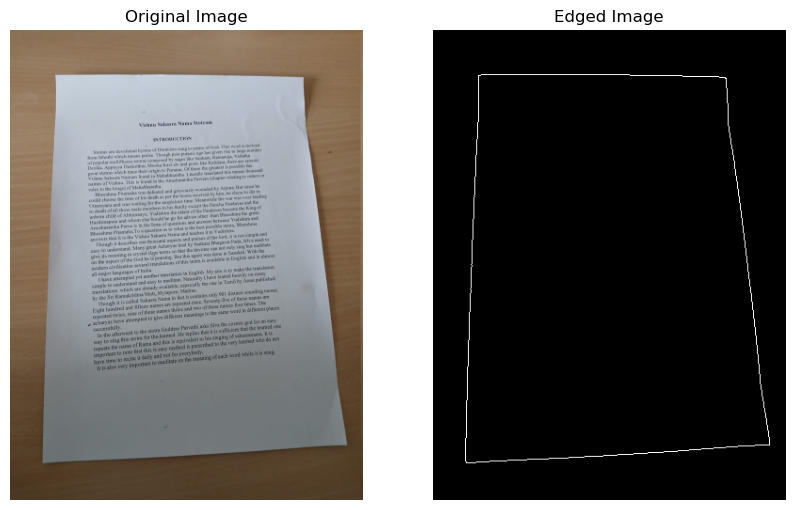

In [108]:
image, edged, ratio = image_preprocess(img1)

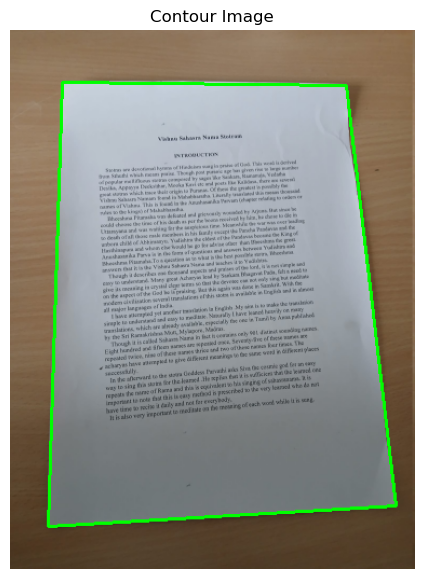

In [109]:
screenCnt = contours(image, edged)

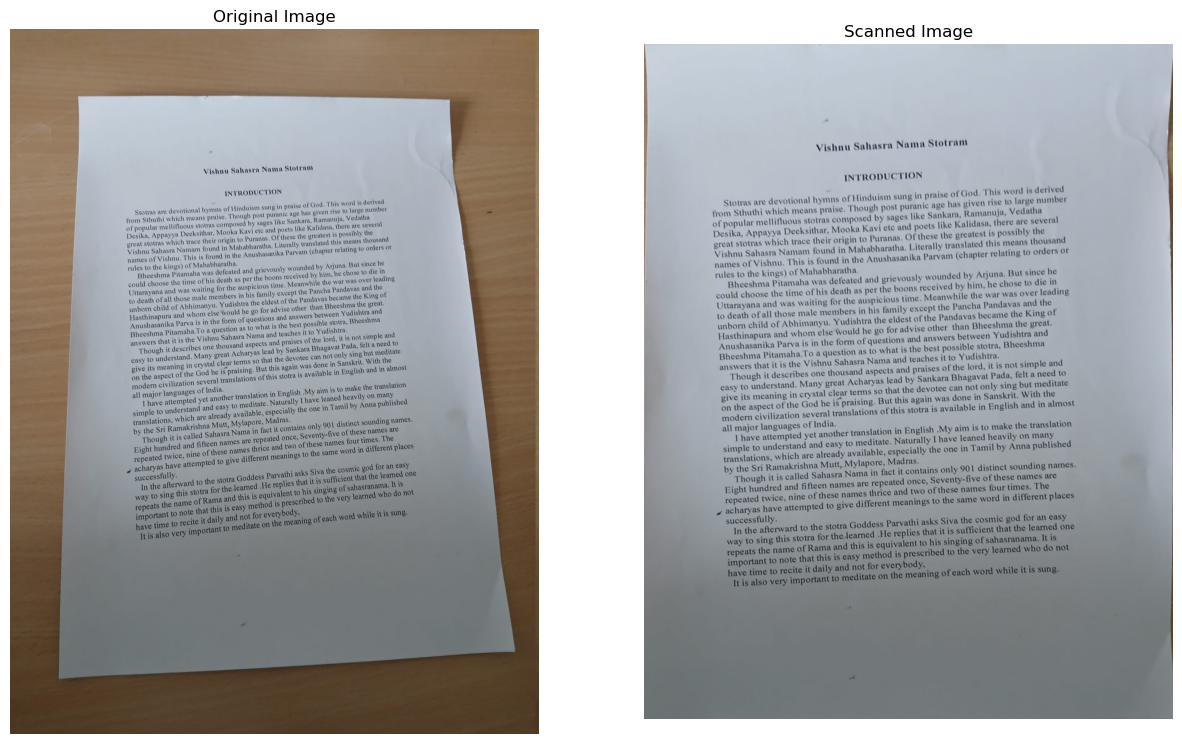

In [110]:
final_scanned(screenCnt, img1, ratio)

# Example 2

In [111]:
img2 = cv2.imread('/home/user/Data Science Portfolio - Likitha/Projects/Document_Scanner/Document-Scanner/Images/image2.jpg')

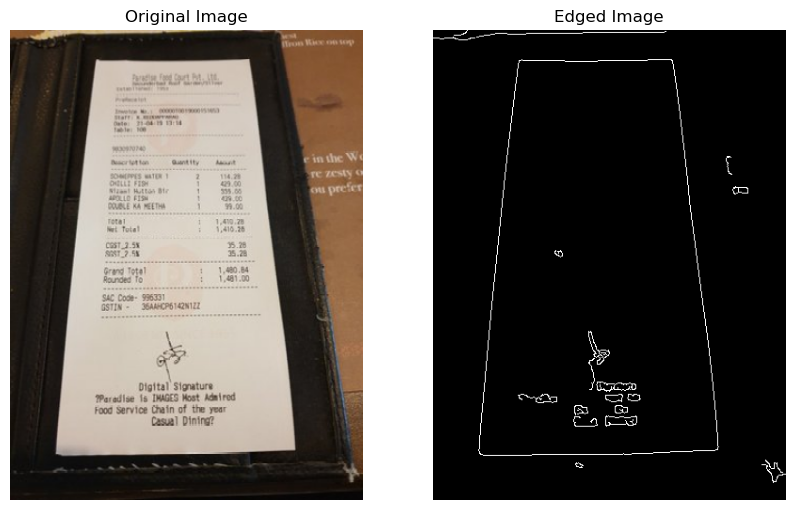

In [112]:
image, edged, ratio = image_preprocess(img2)

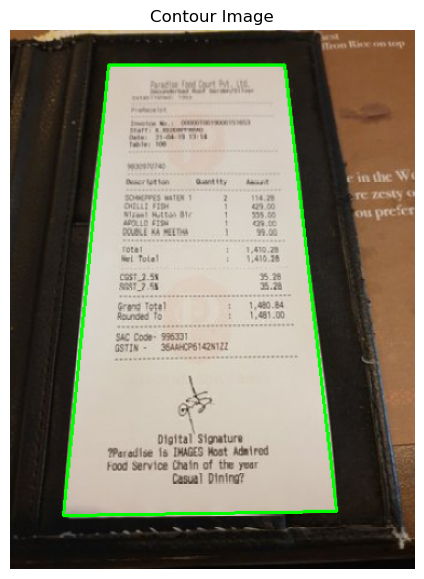

In [113]:
screenCnt = contours(image, edged)

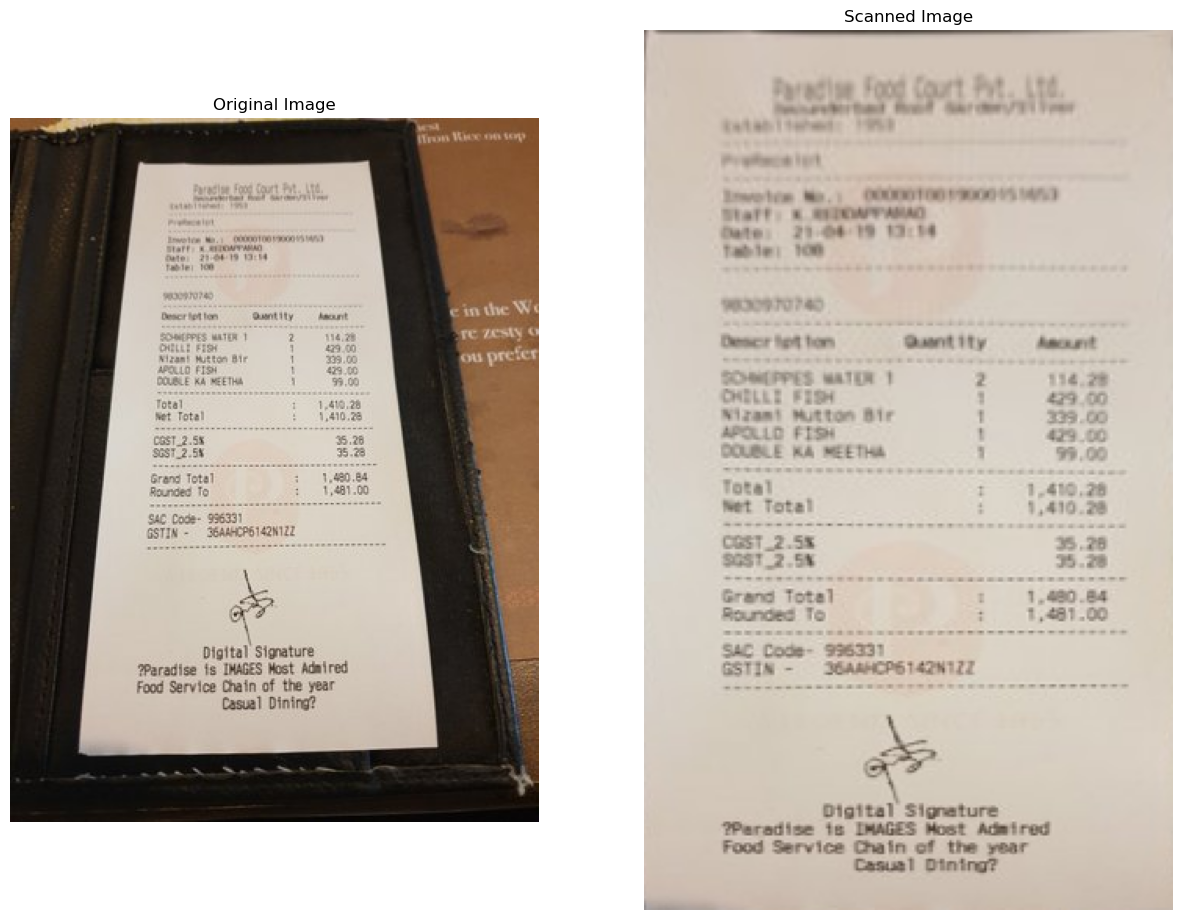

In [114]:
final_scanned(screenCnt, img2, ratio)